In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import ztest


In [3]:
from world import World
from grid_data import Rainfall, SurfaceTemperature
from utils import movmean

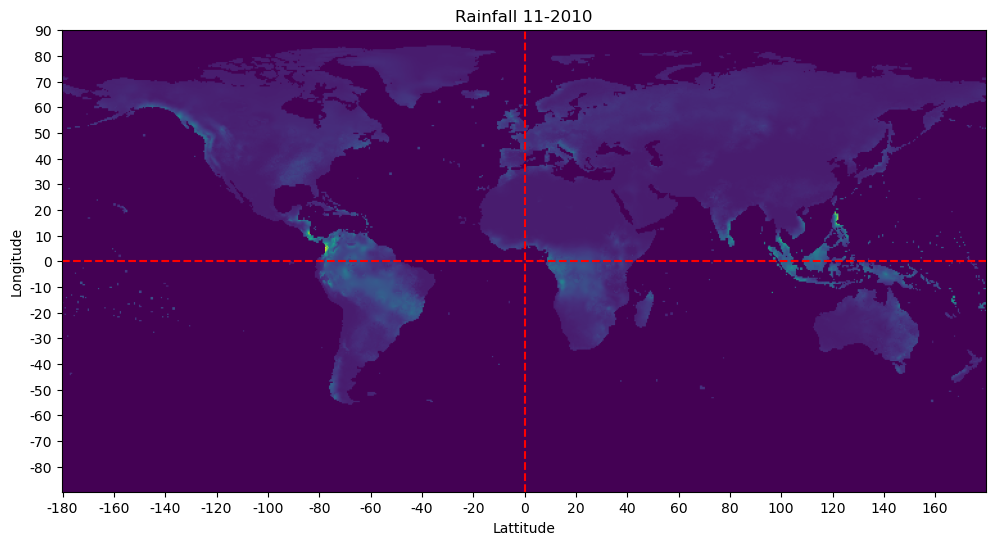

In [4]:
# fetch data
rainfall = Rainfall()
rainfall.fetch_data_years(1901, 2023, delete_file=True)

# get 2001 january for the entire world and plot
ax = rainfall.plot_month(11, 2010)
plt.show()

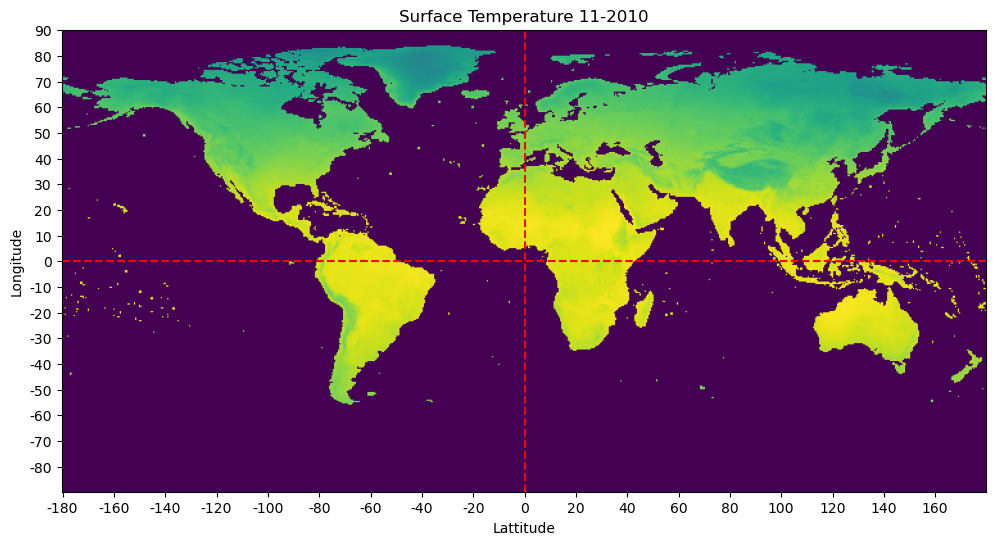

In [5]:
# fetch surface temp data
surf_temp = SurfaceTemperature()
surf_temp.fetch_data_years(1901, 2023, delete_file=True)

ax = surf_temp.plot_month(11, 2010)
plt.show()

In [6]:
data = surf_temp.get_month(11, 2000)
np.amin(data), np.amax(data)

(np.float64(-999.0), np.float64(315.0))

# Create the world object and create lookup array

In [7]:
# create the world object
world = World('tests/aux_files/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
world.create_lookup()

In [8]:
world.iso_to_idx.keys()

dict_keys(['ATA', 'CHL', 'ARG', 'GB1', 'FR1', 'NZ1', 'AU1', 'URY', 'ZAF', 'BRA', 'LSO', 'NAM', 'PRY', 'SWZ', 'BWA', 'MOZ', 'MDG', 'BOL', 'ZWE', 'PER', 'FJI', 'AGO', 'ZMB', 'MWI', 'VUT', 'COD', 'TZA', 'PNG', 'SLB', 'IDN', 'TLS', 'ECU', 'COG', 'KEN', 'COL', 'BDI', 'GAB', 'RWA', 'SOM', 'UGA', 'VEN', 'MYS', 'GUY', 'GNQ', 'SUR', 'CMR', 'CAF', 'ETH', 'SDS', 'LBR', 'CIV', 'NGA', 'BRN', 'GHA', 'THA', 'PHL', 'TGO', 'BEN', 'LKA', 'SLE', 'PAN', 'GIN', 'TCD', 'SOL', 'CRI', 'IND', 'SDN', 'VNM', 'BFA', 'TTO', 'MLI', 'MMR', 'NIC', 'KHM', 'GNB', 'DJI', 'NER', 'SEN', 'ERI', 'YEM', 'SLV', 'HND', 'GMB', 'GTM', 'LAO', 'MEX', 'MRT', 'BLZ', 'SAU', 'OMN', 'JAM', 'DOM', 'US1', 'HTI', 'CH1', 'DZA', 'CU1', 'LBY', 'MAR', 'SAH', 'BGD', 'EGY', 'ARE', 'TWN', 'PAK', 'BHS', 'QAT', 'IRN', 'NPL', 'BTN', 'KWT', 'JOR', 'IRQ', 'AFG', 'IS1', 'TUN', 'JPN', 'SYR', 'LBN', 'KOR', 'GRC', 'CYP', 'TKM', 'ESP', 'TUR', 'PRT', 'ITA', 'TJK', 'UZB', 'PRK', 'AZE', 'ARM', 'KGZ', 'ALB', 'MKD', 'KA1', 'BGR', 'GEO', 'RUS', 'CAN', 'MNG', 'M

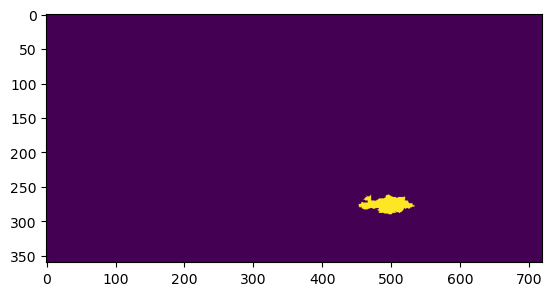

In [9]:
test = np.copy(world.world_array)
idx = world.iso_to_idx['KA1']
test[np.where(test != idx)] = -99999
plt.imshow(test)

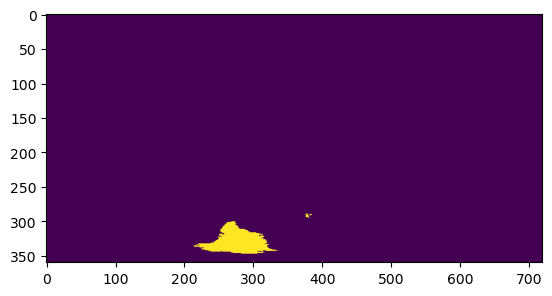

In [10]:
test = np.copy(world.world_array)
idx = world.iso_to_idx['DN1']
test[np.where(test != idx)] = -99999
plt.imshow(test)

In [11]:
iso_change = {'GB1': 'GBR',
              'FR1': 'FRA',
              'NZ1': 'NZL',
              'AU1': 'AUS',
              'US1': 'USA',
              'CH1': 'CHE', # switzerland?
              'CU1': 'CUB',
              'IS1': 'ISL', # iceland
              'KA1': 'KAZ', #??
              'NL1': 'NLD',
              'DN1': 'DNK', #??
              'FI1': 'FIN'
              }

world.change_iso_code(iso_change)

### Quick test to see if country selections make sense

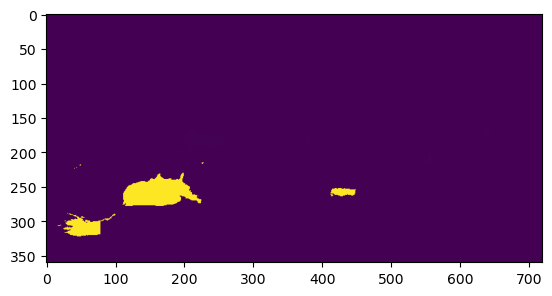

In [12]:
# quick test for selecting country
idx = world.get_grid_points_of_country(iso_code='TUR')
data = np.copy(rainfall.get_month(5, 2007))
data[idx] = 999999
idx = world.get_grid_points_of_country(iso_code='USA')
data[idx] = 999999
plt.imshow(data)
plt.show()

### Plot rainfall totals for Turkey and Syria, just as a test

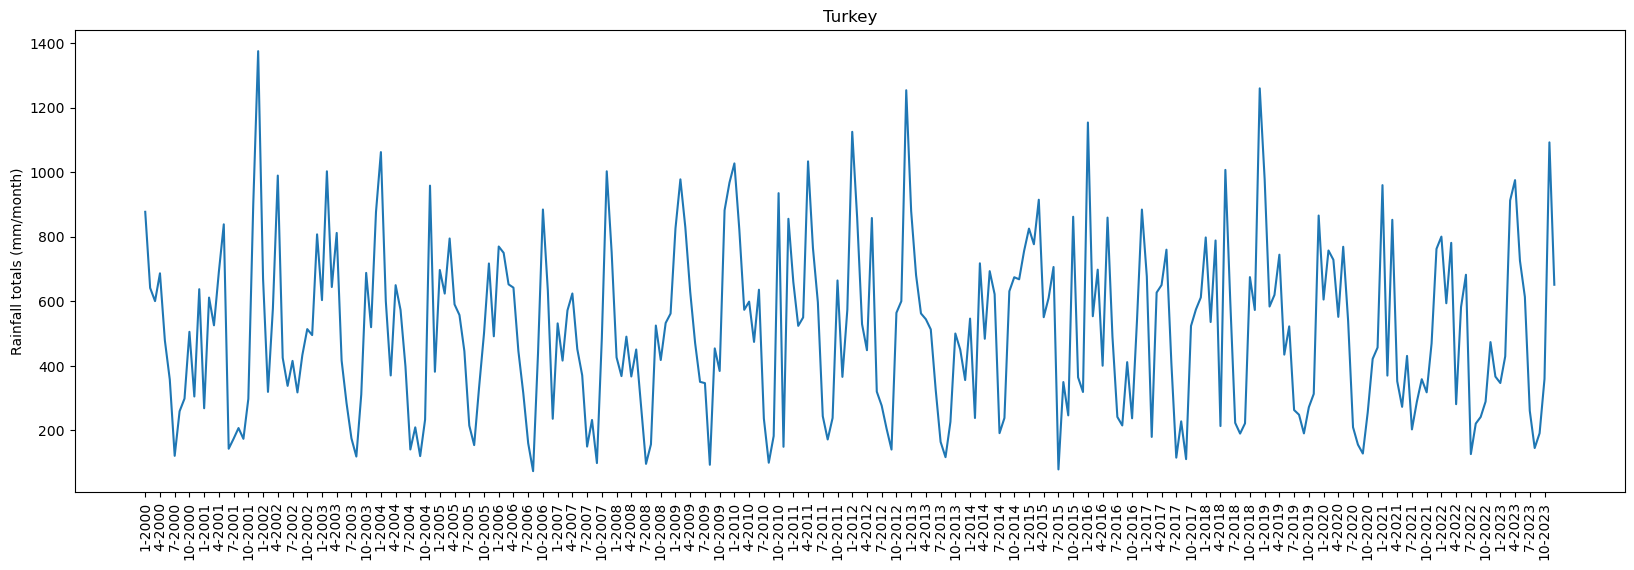

In [13]:
t, dates, totals = rainfall.get_country_avg((1,12), (2000,2023),'TUR', world)
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(t, totals)
ax.set_xticks(t[::3])
ax.set_xticklabels(dates[::3], rotation=90)
ax.set_ylabel('Rainfall totals (mm/month)')
ax.set_title('Turkey')
plt.show()

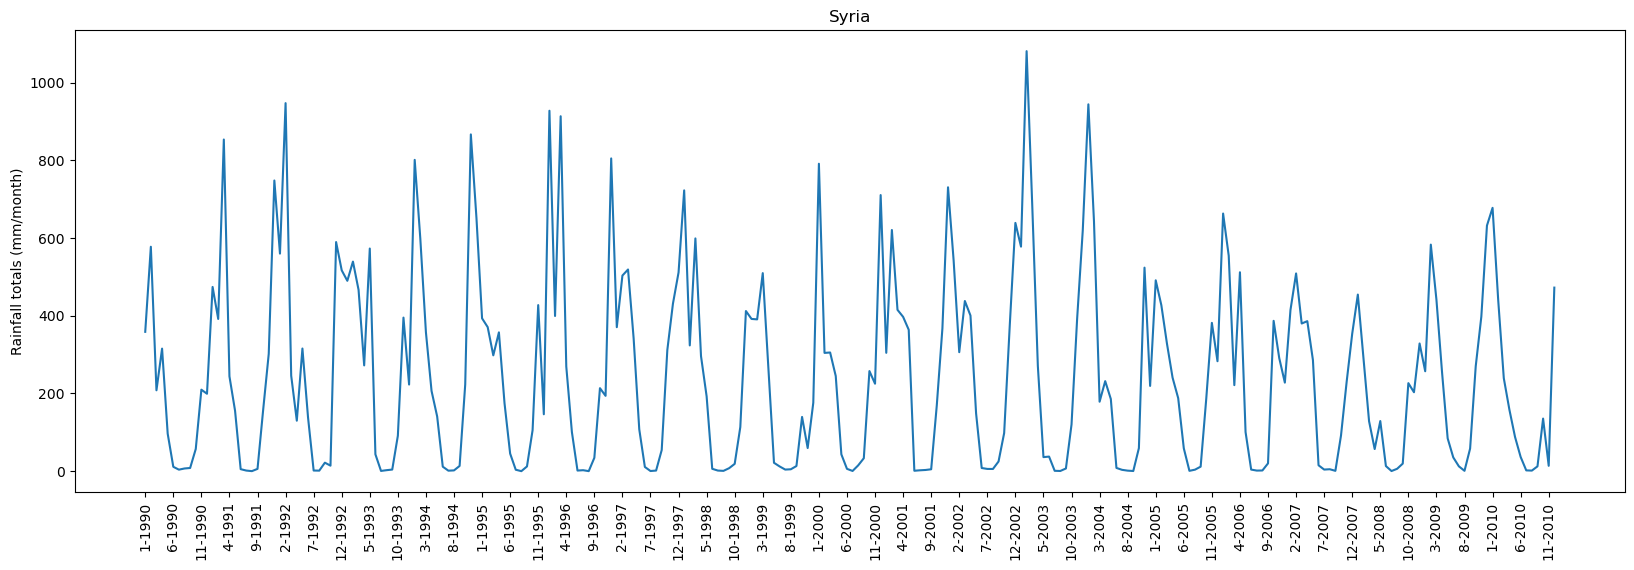

In [14]:
t, dates, totals = rainfall.get_country_avg((1,12), (1990,2010),'SYR', world)
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(t, totals)
ax.set_xticks(t[::5])
ax.set_xticklabels(dates[::5], rotation=90)
ax.set_ylabel('Rainfall totals (mm/month)')
ax.set_title('Syria')
plt.show()

### Syria 6-month winter averages (November-April) as plotted in Fig.1 of [Kelley et al.](https://www.pnas.org/doi/epdf/10.1073/pnas.1421533112)

The orange line is a moving average with a window of 50 years, meant to depict the overall decrease trend starting around ~1990.

p-value for pre 1930s temperature to be larger is 0.07485028305619477, with a test statistic of 1.4405899331246053.


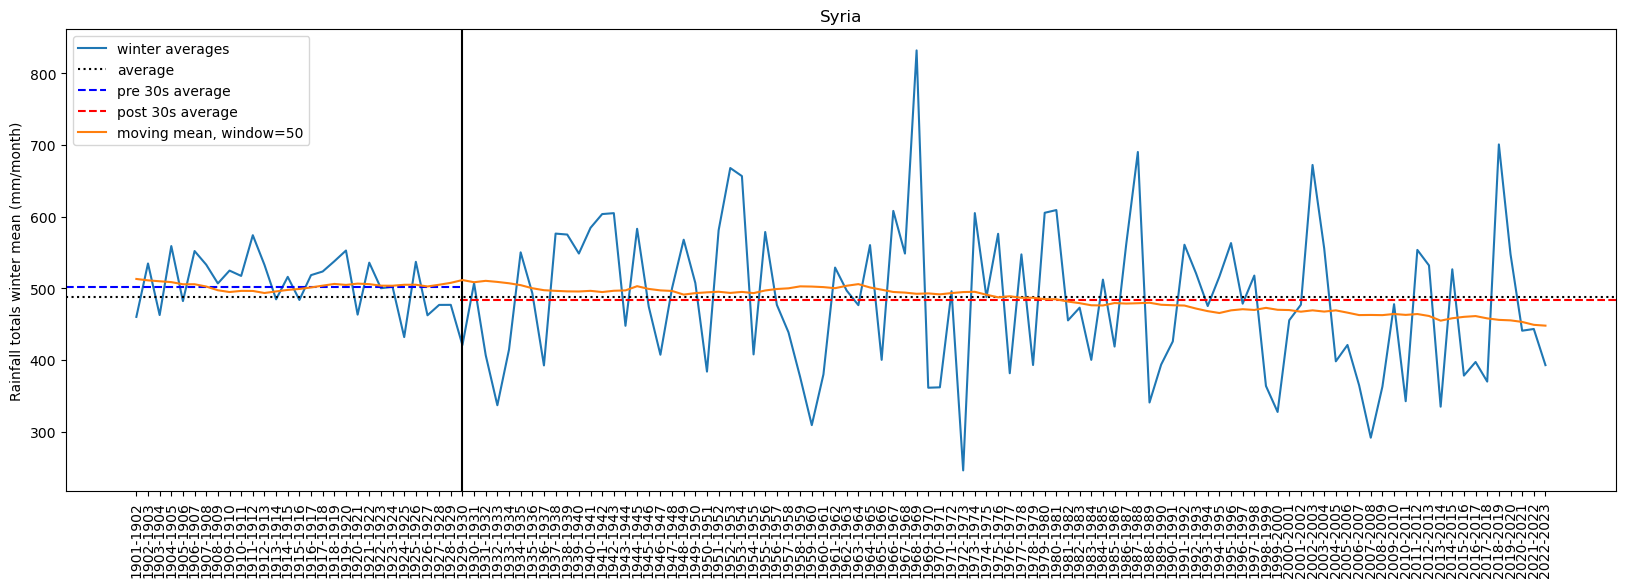

In [15]:
t, dates, winter_means = rainfall.get_country_winter_mean((1901,2023), 'SYR', world)

# quick hypothesis testing with H_0: mu_1=mu_2, H_a: mu_2>mu_1
pre_30s = winter_means[:31]
post_30s = winter_means[31:]
pop_mean_diff = np.mean(post_30s)-np.mean(pre_30s)
z, p = ztest(x1=pre_30s, x2=post_30s, alternative='larger', usevar='unequal')
print(f"p-value for pre 1930s temperature to be larger is {p}, with a test statistic of {z}.")

fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(t, winter_means, label='winter averages')
ax.axhline(np.mean(winter_means), color='k', linestyle='dotted', label='average')
ax.axhline(np.mean(winter_means[:31]), color='b', linestyle='dashed', xmax=31/len(dates), label='pre 30s average')
ax.axhline(np.mean(winter_means[31:]), color='r', linestyle='dashed', xmin=31/len(dates), label='post 30s average')
ax.axvline(28, color='k')
ax.plot(t, movmean(winter_means, window=50), label='moving mean, window=50')

ax.set_xticks(t)
ax.set_xticklabels(dates, rotation=90)
ax.set_ylabel('Rainfall totals winter mean (mm/month)')
ax.set_title('Syria')
ax.legend()
plt.show()

Try different cutoffs for the year for the z-test. (This is probably p-hacking)

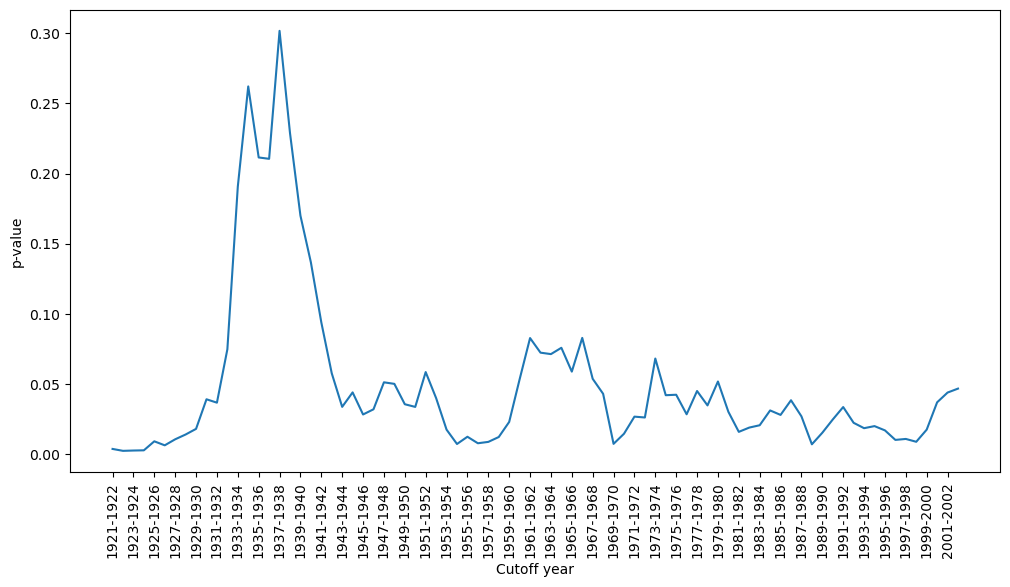

In [16]:
cutoffs = []
pvals = []
margin = 20
for i in range(margin,len(winter_means)-margin):
    pre = winter_means[:i]
    post = winter_means[i:]
    z, p = ztest(x1=pre, x2=post, alternative='larger', usevar='unequal')
    cutoffs.append(i)
    pvals.append(p)

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(cutoffs, pvals)
ax.set_xlabel('Cutoff year')
ax.set_ylabel('p-value')
ax.set_xticks(cutoffs[::2])
ax.set_xticklabels(dates[margin:-margin][::2], rotation=90)
plt.show()

Same for Turkey, just out of curiosity. Note that a similar trend exists, but the total rainfall is an order of magnitude larger. This suggests to me that maybe if the total rainfall is large enough, the economical impacts of a drought may be more robust to rainfall variation. 

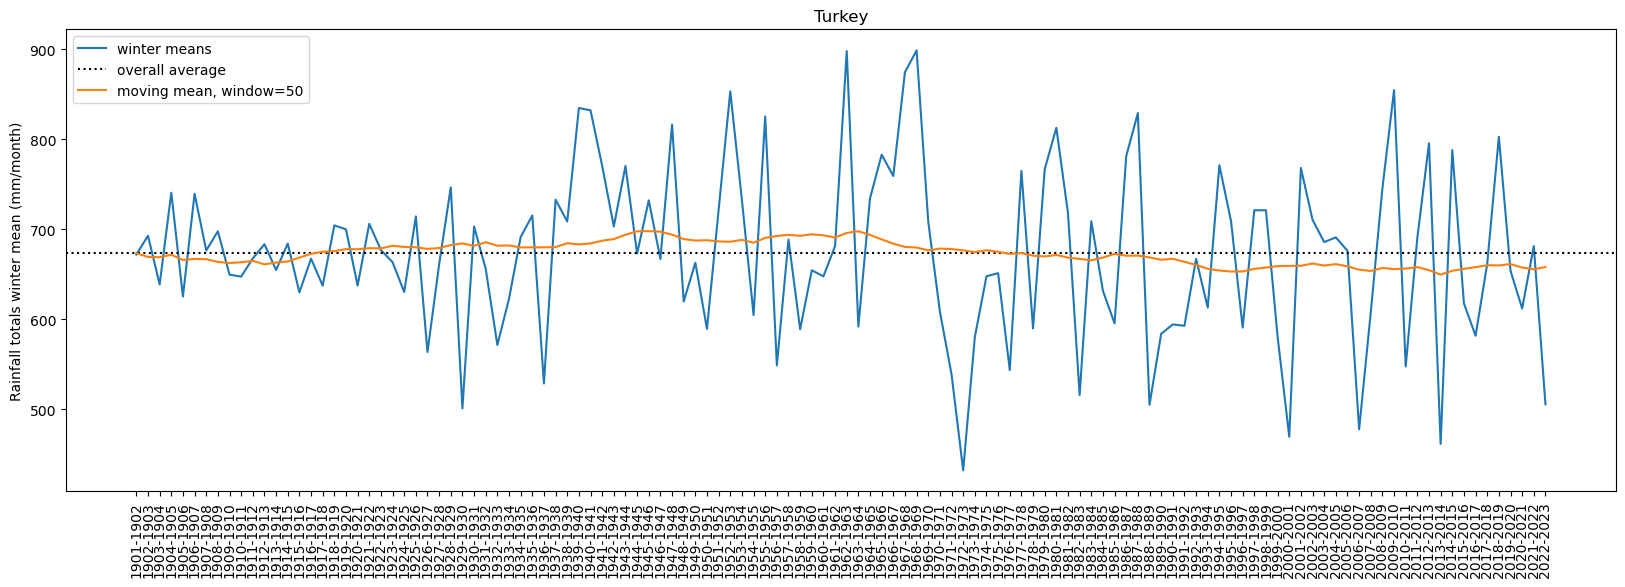

In [17]:
t, dates, winter_means = rainfall.get_country_winter_mean((1901,2023), 'TUR', world)
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(t, winter_means, label='winter means')
ax.axhline(np.mean(winter_means), color='k', linestyle='dotted', label='overall average')
ax.plot(t, movmean(winter_means, window=50), label='moving mean, window=50')
ax.set_xticks(t)
ax.set_xticklabels(dates, rotation=90)
ax.set_ylabel('Rainfall totals winter mean (mm/month)')
ax.set_title('Turkey')
ax.legend()
plt.show()

Rainfall variation (as numerical differentiation)

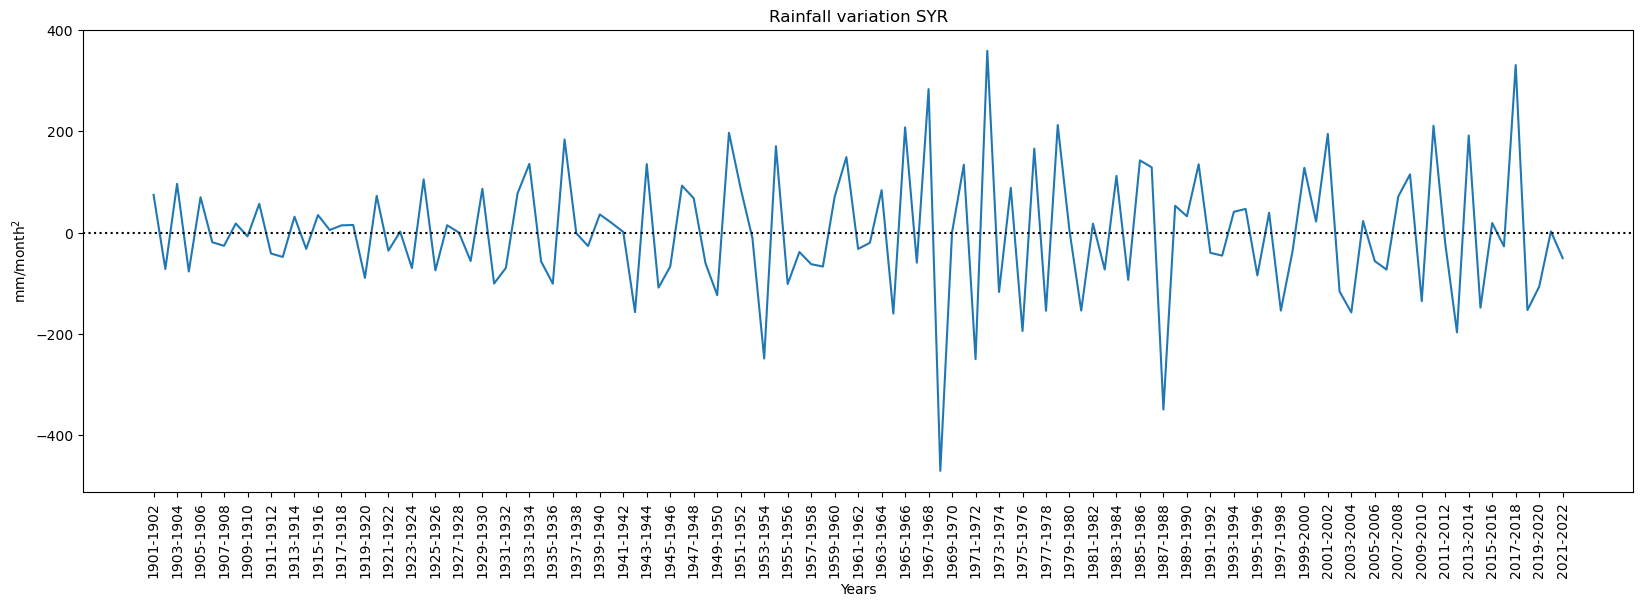

In [18]:
t, dates, winter_means = rainfall.get_country_winter_mean((1901,2023), 'SYR', world)
variation = np.diff(winter_means)
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(t[:-1], variation)
ax.set_xticks(t[::2])
ax.set_xticklabels(dates[::2], rotation=90)
ax.axhline(0, color='k', linestyle='dotted')
ax.set_title('Rainfall variation SYR')
ax.set_xlabel('Years')
ax.set_ylabel('mm/month$^2$')
plt.show()

## Compare with GDP

In [19]:
df = pd.read_csv("https://ourworldindata.org/grapher/gdp-worldbank-constant-usd.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})
df.head(5)

,Entity,Code,Year,ny_gdp_mktp_kd
0,Afghanistan,AFG,2000,6.206548e+09
1,Afghanistan,AFG,2001,5.621148e+09
2,Afghanistan,AFG,2002,7.228796e+09
3,Afghanistan,AFG,2003,7.867264e+09
4,Afghanistan,AFG,2004,7.978516e+09


In [20]:
df['Code'].unique()

array(['AFG', 'ALB', 'DZA', 'ASM', 'AND', 'AGO', 'ATG', 'ARG', 'ARM',
       'ABW', 'AUS', 'AUT', 'AZE', 'BHS', 'BHR', 'BGD', 'BRB', 'BLR',
       'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL', 'BIH', 'BWA', 'BRA',
       'BRN', 'BGR', 'BFA', 'BDI', 'KHM', 'CMR', 'CAN', 'CPV', 'CYM',
       'CAF', 'TCD', 'OWID_CIS', 'CHL', 'CHN', 'COL', 'COM', 'COG', 'CRI',
       'CIV', 'HRV', 'CUB', 'CUW', 'CYP', 'CZE', 'COD', 'DNK', 'DJI',
       'DMA', 'DOM', nan, 'TLS', 'ECU', 'EGY', 'SLV', 'GNQ', 'ERI', 'EST',
       'SWZ', 'ETH', 'FJI', 'FIN', 'FRA', 'PYF', 'GAB', 'GMB', 'GEO',
       'DEU', 'GHA', 'GRC', 'GRL', 'GRD', 'GUM', 'GTM', 'GIN', 'GNB',
       'GUY', 'HTI', 'HND', 'HKG', 'HUN', 'ISL', 'IND', 'IDN', 'IRN',
       'IRQ', 'IRL', 'IMN', 'ISR', 'ITA', 'JAM', 'JPN', 'JOR', 'KAZ',
       'KEN', 'KIR', 'OWID_KOS', 'KWT', 'KGZ', 'LAO', 'LVA', 'LBN', 'LSO',
       'LBR', 'LBY', 'LIE', 'LTU', 'LUX', 'MAC', 'MDG', 'MWI', 'MYS',
       'MDV', 'MLI', 'MLT', 'MHL', 'MRT', 'MUS', 'MEX', 'FSM', 'MDA',
     

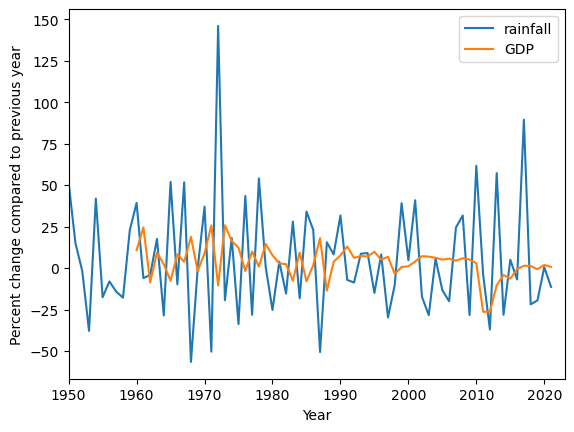

In [21]:
year = df[df['Code'] == 'SYR'].Year

gdp = df[df['Code'] == 'SYR'].ny_gdp_mktp_kd
gdp_var = 100*np.diff(gdp)/gdp[:-1]

t, dates, winter_means = rainfall.get_country_winter_mean((1901,2023), 'SYR', world)
variation = 100*np.diff(winter_means)/winter_means[:-1]
tx = np.arange(1901, 2022) 

plt.plot(tx, variation, label='rainfall')
plt.plot(year[:-1], gdp_var, label='GDP')
plt.xlabel('Year')
plt.ylabel('Percent change compared to previous year')
plt.xlim(1950,2023)
plt.legend()
plt.show()

OLS attempt at rainfall variation and change in GDP for Syria

[[0.         0.03477456]] 0.015191192251121977


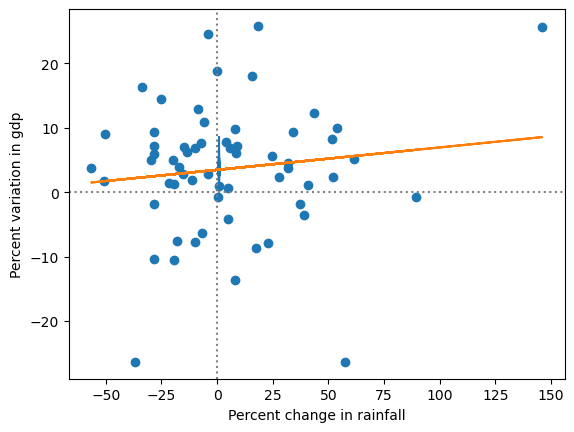

In [22]:
from sklearn.linear_model import LinearRegression

year = df[df['Code'] == 'SYR'].Year

gdp = df[df['Code'] == 'SYR'].ny_gdp_mktp_kd
gdp_var = 100*np.diff(gdp)/gdp[:-1]

t, dates, winter_means = rainfall.get_country_winter_mean((1960,2023), 'SYR', world)
variation = 100*np.diff(winter_means)/winter_means[:-1]
tx = np.arange(1961, 2022)

plt.scatter(variation[1:], gdp_var[:-1])
plt.xlabel('Percent change in rainfall')
plt.ylabel('Percent variation in gdp')
plt.axhline(0, color='gray', linestyle='dotted')
plt.axvline(0, color='gray', linestyle='dotted')

X = np.hstack((np.ones((len(variation[1:]), 1)), variation[1:].reshape(-1, 1)))
y = gdp_var[:-1].to_numpy().reshape(-1, 1)
reg = LinearRegression().fit(X, y)
print(reg.coef_, reg.score(X, y))
plt.plot(X, reg.predict(X))
plt.show()

Same, but not normalized

[[     0.         603848.45102385]] 0.002775611096733299


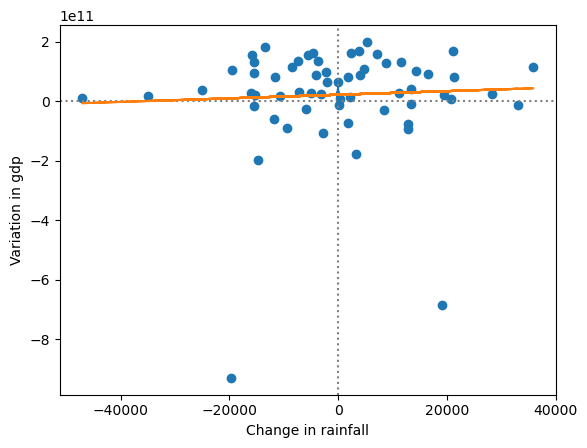

In [23]:
year = df[df['Code'] == 'SYR'].Year

gdp = df[df['Code'] == 'SYR'].ny_gdp_mktp_kd
gdp_var = 100*np.diff(gdp)

t, dates, winter_means = rainfall.get_country_winter_mean((1960,2023), 'SYR', world)
variation = 100*np.diff(winter_means)

plt.scatter(variation[1:], gdp_var[:-1])
plt.xlabel('Change in rainfall')
plt.ylabel('Variation in gdp')
plt.axhline(0, color='gray', linestyle='dotted')
plt.axvline(0, color='gray', linestyle='dotted')

X = np.hstack((np.ones((len(variation[1:]), 1)), variation[1:].reshape(-1, 1)))
y = gdp_var[:-1].reshape(-1, 1)
reg = LinearRegression().fit(X, y)
print(reg.coef_, reg.score(X, y))
plt.plot(X, reg.predict(X))
plt.show()

Plotting rainfall variation and change in GDP for Turkey

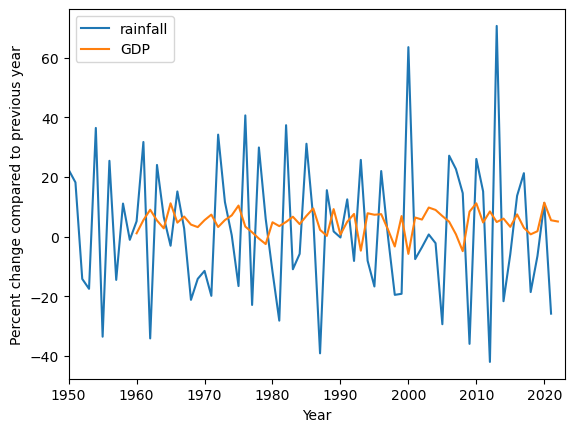

In [24]:
year = df[df['Code'] == 'TUR'].Year

gdp = df[df['Code'] == 'TUR'].ny_gdp_mktp_kd
gdp_var = 100*np.diff(gdp)/gdp[:-1]

t, dates, winter_means = rainfall.get_country_winter_mean((1901,2023), 'TUR', world)
variation = 100*np.diff(winter_means)/winter_means[:-1]
tx = np.arange(1901, 2022)

plt.plot(tx, variation, label='rainfall')
plt.plot(year[:-1], gdp_var, label='GDP')
plt.xlabel('Year')
plt.ylabel('Percent change compared to previous year')
plt.xlim(1950,2023)
plt.legend()
plt.show()

## Function to calculate variations as described in [Miguel et al. 2004](http://emiguel.econ.berkeley.edu/wordpress/wp-content/uploads/2021/03/Paper__Economic_Shocks_and_Civil_Conflict.pdf):

For rainfall $R$, the variation is
$$
\Delta R_{it} = \frac{R_{it}-R_{i,t-1}}{R_{i,t-1}},
$$
where $i$ denotes the country and $t$ denotes the year.

In [25]:
from utils import diff

# Basic OLS attempts

In [26]:
# design matrix roughly following the rainfall paper

year = df[df['Code'] == 'SYR'].Year
gdp = df[df['Code'] == 'SYR'].ny_gdp_mktp_kd

t, dates, winter_means = rainfall.get_country_winter_mean((1960,2023), 'SYR', world)

r_it = diff(winter_means)
r_it_1 = diff(winter_means, lag=1)


X = np.hstack((np.ones((len(r_it_1), 1)), r_it[1:].reshape(-1, 1)))
X = np.hstack((X, r_it_1.reshape(-1, 1)))
X = np.hstack((X, year[2:].to_numpy().reshape(-1, 1)))

gdp_var = diff(gdp)
y = gdp_var[1:].reshape(-1, 1)

reg = LinearRegression().fit(X, y)
print(reg.coef_, reg.score(X, y))

[[ 0.         -0.05400169  0.08884867 -0.00192038]] 0.3197112384553029


In [27]:
# design matrix roughly following the rainfall paper

year = df[df['Code'] == 'TUR'].Year
year = year[:-1]

gdp = df[df['Code'] == 'TUR'].ny_gdp_mktp_kd
gdp = gdp[:-1]

t, dates, winter_means = rainfall.get_country_winter_mean((1960,2023), 'TUR', world)

r_it = diff(winter_means)
r_it_1 = diff(winter_means, lag=1)


X = np.hstack((np.ones((len(r_it_1), 1)), r_it[1:].reshape(-1, 1)))
X = np.hstack((X, r_it_1.reshape(-1, 1)))
X = np.hstack((X, year[2:].to_numpy().reshape(-1, 1)))

gdp_var = diff(gdp)
y = gdp_var[1:].reshape(-1, 1)

reg = LinearRegression().fit(X, y)
print(reg.coef_, reg.score(X, y))


[[ 0.00000000e+00 -4.64031449e-02 -9.74145575e-03 -7.12975849e-05]] 0.0696873396629395


In [28]:
year = df[df['Code'] == 'RWA'].Year
year = year[:-1]

gdp = df[df['Code'] == 'RWA'].ny_gdp_mktp_kd
gdp = gdp[:-1]

t, dates, winter_means = rainfall.get_country_winter_mean((1960,2023), 'RWA', world)

r_it = diff(winter_means)
r_it_1 = diff(winter_means, lag=1)


X = np.hstack((np.ones((len(r_it_1), 1)), r_it[1:].reshape(-1, 1)))
X = np.hstack((X, r_it_1.reshape(-1, 1)))
X = np.hstack((X, year[2:].to_numpy().reshape(-1, 1)))

gdp_var = diff(gdp)
y = gdp_var[1:].reshape(-1, 1)

reg = LinearRegression().fit(X, y)
print(reg.coef_, reg.score(X, y))


[[ 0.          0.01435919 -0.01330404  0.00079599]] 0.02471973145890427


In [29]:
year = df[df['Code'] == 'TZA'].Year
year = year[:-1]

gdp = df[df['Code'] == 'TZA'].ny_gdp_mktp_kd
gdp = gdp[:-1]

t, dates, winter_means = rainfall.get_country_winter_mean((1960,2023), 'TZA', world)

r_it = diff(winter_means)
r_it_1 = diff(winter_means, lag=1)


X = np.hstack((np.ones((len(r_it_1), 1)), r_it[1:].reshape(-1, 1)))
X = np.hstack((X, r_it_1.reshape(-1, 1)))
X = np.hstack((X, year[2:].to_numpy().reshape(-1, 1)))

gdp_var = diff(gdp)
y = gdp_var[1:].reshape(-1, 1)

reg = LinearRegression().fit(X, y)
print(reg.coef_, reg.score(X, y))


[[0.         0.02506661 0.01809996 0.00082745]] 0.04922830434691261


# Join multiple datasets

- Annual GDP data
- Annual winter rainfall data
- Share of GDP from agriculture
- Oil rents as a share of GDP
- Democracy index Polity V
- Ethnic fractionalization index

In [30]:
from csv_fetcher import CsvFetcher

In [31]:
fetcher = CsvFetcher('https://ourworldindata.org/grapher/agriculture-share-gdp.csv?v=1&csvType=full&useColumnShortNames=true')
agricultural_share = fetcher.fetch()
agricultural_share.head(5)

iso_name = agricultural_share.copy()
iso_name = iso_name[['Entity', 'Code']].drop_duplicates(ignore_index=True)

In [32]:
agricultural_share[agricultural_share.isna().any(axis=1)]

# remove region info
agricultural_share.dropna(inplace=True)


In [33]:
iso_name

,Entity,Code
0,Afghanistan,AFG
1,Albania,ALB
2,Algeria,DZA
3,Andorra,AND
4,Angola,AGO
...,...,...
215,Vietnam,VNM
216,World,OWID_WRL
217,Yemen,YEM
218,Zambia,ZMB


In [34]:
print(agricultural_share['Code'].unique(), agricultural_share['Code'].nunique())

['AFG' 'ALB' 'DZA' 'AND' 'AGO' 'ATG' 'ARG' 'ARM' 'ABW' 'AUS' 'AUT' 'AZE'
 'BHS' 'BHR' 'BGD' 'BRB' 'BLR' 'BEL' 'BLZ' 'BEN' 'BMU' 'BTN' 'BOL' 'BIH'
 'BWA' 'BRA' 'BRN' 'BGR' 'BFA' 'BDI' 'KHM' 'CMR' 'CAN' 'CPV' 'CYM' 'CAF'
 'TCD' 'OWID_CIS' 'CHL' 'CHN' 'COL' 'COM' 'COG' 'CRI' 'CIV' 'HRV' 'CUB'
 'CUW' 'CYP' 'CZE' 'COD' 'DNK' 'DJI' 'DMA' 'DOM' 'TLS' 'ECU' 'EGY' 'SLV'
 'GNQ' 'ERI' 'EST' 'SWZ' 'ETH' 'FJI' 'FIN' 'FRA' 'PYF' 'GAB' 'GMB' 'GEO'
 'DEU' 'GHA' 'GRC' 'GRL' 'GRD' 'GTM' 'GIN' 'GNB' 'GUY' 'HTI' 'HND' 'HKG'
 'HUN' 'ISL' 'IND' 'IDN' 'IRN' 'IRQ' 'IRL' 'IMN' 'ISR' 'ITA' 'JAM' 'JPN'
 'JOR' 'KAZ' 'KEN' 'KIR' 'OWID_KOS' 'KWT' 'KGZ' 'LAO' 'LVA' 'LBN' 'LSO'
 'LBR' 'LBY' 'LIE' 'LTU' 'LUX' 'MDG' 'MWI' 'MYS' 'MDV' 'MLI' 'MLT' 'MHL'
 'MRT' 'MUS' 'MEX' 'FSM' 'MDA' 'MNG' 'MNE' 'MAR' 'MOZ' 'MMR' 'NAM' 'NPL'
 'NLD' 'NCL' 'NZL' 'NIC' 'NER' 'NGA' 'MKD' 'NOR' 'OMN' 'PAK' 'PLW' 'PSE'
 'PAN' 'PNG' 'PRY' 'PER' 'PHL' 'POL' 'PRT' 'PRI' 'QAT' 'ROU' 'RUS' 'RWA'
 'KNA' 'LCA' 'VCT' 'WSM' 'SMR' 'STP' 'SAU' 'SEN' 'SRB

In [35]:
from missing_value_handler import add_missing_years, fill_na

In [36]:
agricultural_share = add_missing_years(agricultural_share,
                                       min_year=1960,
                                       max_year=2023,
                                       year_name='Year',
                                       ref_column='Code')

In [37]:
agricultural_share[agricultural_share['Code']=='AFG']
agricultural_share = agricultural_share.drop('Entity', axis=1)

In [38]:
fill_na(agricultural_share, 'nv_agr_totl_zs', 'Code', 'AFG', method='max')
agricultural_share[agricultural_share['Code']=='AFG']

,Code,Year,nv_agr_totl_zs
0,AFG,2002,38.627890
1,AFG,2003,37.418854
2,AFG,2004,29.721067
3,AFG,2005,31.114855
4,AFG,2006,28.635970
...,...,...,...
0,AFG,1997,38.627890
0,AFG,1998,38.627890
0,AFG,1999,38.627890
0,AFG,2000,38.627890


In [39]:
# do the same to all the other countries
for country in agricultural_share['Code'].unique():
    fill_na(agricultural_share, 'nv_agr_totl_zs', 'Code', country, method='max')

agricultural_share = agricultural_share.sort_values(by=['Code','Year'])

In [40]:
agricultural_share.sample(10)

,Code,Year,nv_agr_totl_zs
7575,SOM,1983,60.710520
7386,SLE,2016,36.914402
1612,COL,1967,26.892218
7358,SLE,1988,43.313484
0,OWID_WRL,1971,7.070384
0,LBN,1992,6.794856
1575,CHN,1989,24.611551
6539,PRY,1981,27.767328
4159,JAM,2015,6.308336
8003,SUR,1980,7.735849


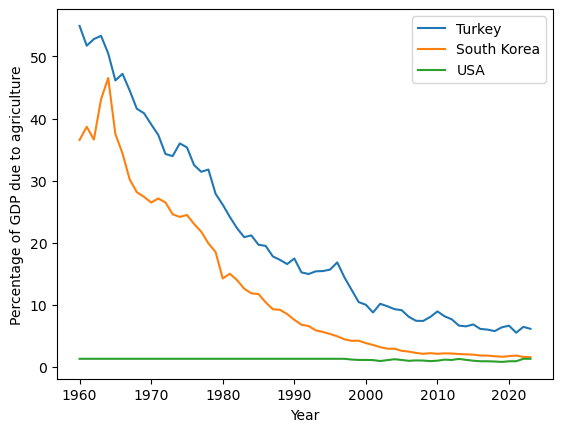

In [41]:
test = agricultural_share[agricultural_share['Code']=='TUR']
plt.plot(test['Year'], test['nv_agr_totl_zs'], label='Turkey')

test = agricultural_share[agricultural_share['Code']=='KOR']
plt.plot(test['Year'], test['nv_agr_totl_zs'], label='South Korea')

test = agricultural_share[agricultural_share['Code']=='USA']
plt.plot(test['Year'], test['nv_agr_totl_zs'], label='USA')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Percentage of GDP due to agriculture')
plt.show()

In [42]:
fetcher = CsvFetcher('https://ourworldindata.org/grapher/oil-rents-as-a-share-of-gdp.csv?v=1&csvType=full&useColumnShortNames=true')
oil_rent = fetcher.fetch()
oil_rent = oil_rent.drop('Entity', axis=1)
oil_rent = oil_rent.dropna()
oil_rent = add_missing_years(oil_rent,
                             min_year=1960,
                             max_year=2023,
                             year_name='Year',
                             ref_column='Code')

for country in oil_rent['Code'].unique():
    fill_na(oil_rent, 'ny_gdp_petr_rt_zs', 'Code', country, method='min')

oil_rent = oil_rent.sort_values(by=['Code', 'Year'])
oil_rent.reset_index(drop=True, inplace=True)

oil_rent.sample(10)

,Code,Year,ny_gdp_petr_rt_zs
3608,ESP,1984,0.135159
2011,CAN,1987,1.430570
11862,UGA,1982,0.000000
3304,DOM,2000,0.000000
126,AFG,2022,0.005149
652,AUT,1972,0.046100
5086,HTI,1990,0.000000
8986,PAK,1986,0.471894
5594,ISR,1986,0.000293
9781,ROU,2013,0.818029


In [43]:
oil_rent[oil_rent.isna().any(axis=1)]

,Code,Year,ny_gdp_petr_rt_zs


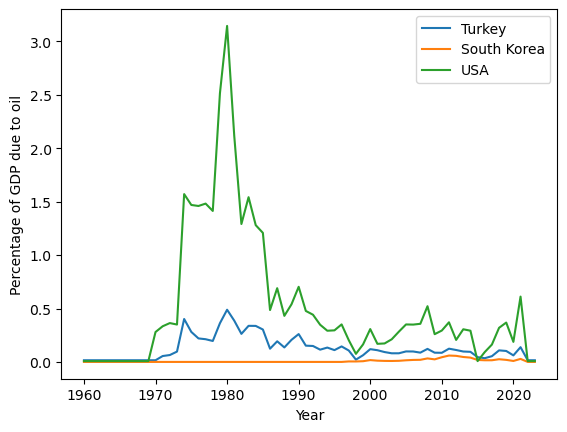

In [44]:
test = oil_rent[oil_rent['Code']=='TUR']
plt.plot(test['Year'], test['ny_gdp_petr_rt_zs'], label='Turkey')

test = oil_rent[oil_rent['Code']=='KOR']
plt.plot(test['Year'], test['ny_gdp_petr_rt_zs'], label='South Korea')

test = oil_rent[oil_rent['Code']=='USA']
plt.plot(test['Year'], test['ny_gdp_petr_rt_zs'], label='USA')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Percentage of GDP due to oil') # is this true?
plt.show()

In [45]:
fetcher = CsvFetcher('https://ourworldindata.org/grapher/democracy-index-polity.csv?v=1&csvType=full&useColumnShortNames=true')
democracy_index = fetcher.fetch()
democracy_index = democracy_index.drop('Entity', axis=1)
democracy_index = add_missing_years(democracy_index,
                                    min_year=1960,
                                    max_year=2023,
                                    year_name='Year',
                                    ref_column='Code')

for country in democracy_index['Code'].unique():
    fill_na(democracy_index, 'democracy_polity', 'Code', country, method='mean')

democracy_index = democracy_index.sort_values(by=['Code','Year'])

democracy_index.head(5)

,Code,Year,democracy_polity
0,AFG,1800,-6.0
1,AFG,1801,-6.0
2,AFG,1802,-6.0
3,AFG,1803,-6.0
4,AFG,1804,-6.0


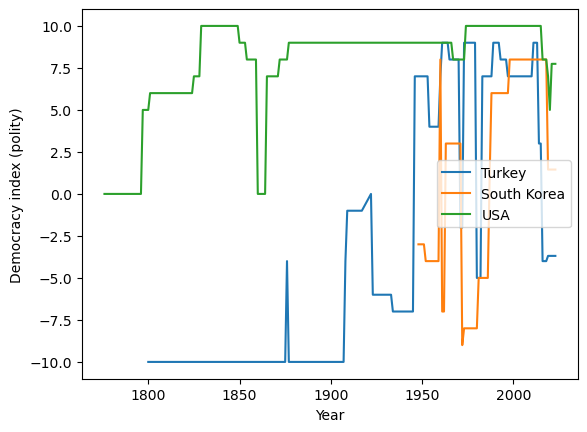

In [46]:
test = democracy_index[democracy_index['Code'] == 'TUR']
plt.plot(test['Year'], test['democracy_polity'], label='Turkey')

test = democracy_index[democracy_index['Code'] == 'KOR']
plt.plot(test['Year'], test['democracy_polity'], label='South Korea')

test = democracy_index[democracy_index['Code'] == 'USA']
plt.plot(test['Year'], test['democracy_polity'], label='USA')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Democracy index (polity)')
plt.show()

In [47]:
fetcher = CsvFetcher('https://cadmus.eui.eu/bitstream/handle/1814/64606/Historical_Index_of_Ethnic_Fractionalisation_Dataset.csv?sequence=3&isAllowed=y')
ethnic_fractionation = fetcher.fetch()
ethnic_fractionation = add_missing_years(ethnic_fractionation,
                                         min_year=1960,
                                         max_year=2023,
                                         year_name='Year',
                                         ref_column='Country')

for country in ethnic_fractionation['Country'].unique():
    fill_na(ethnic_fractionation, 'EFindex', 'Country', country, method='max')

ethnic_fractionation = ethnic_fractionation.sort_values(by=['Country', 'Year'])
ethnic_fractionation.rename(columns={'Country':'Entity'}, inplace=True)
ethnic_fractionation.sample(10)

,Entity,Year,EFindex
588,German Democratic Republic,1989,0.007
3317,Burundi,2005,0.301
0,Ethiopia,2021,0.806
5328,Panama,1976,0.526
8785,Fiji,1991,0.559
7730,Bhutan,2009,0.644
8327,Republic of Vietnam,1973,0.235
3634,Zambia,1997,0.764
4316,Libya,1974,0.168
0,Czech Republic,1970,0.371


In [48]:
print(iso_name.Entity.to_list())

['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Cayman Islands', 'Central African Republic', 'Chad', 'Channel Islands', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'East Asia and Pacific (WB)', 'East Timor', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Europe and Central Asia (WB)', 'European Union (27)', 'Faeroe Islands', 'Fiji', 'Finland', 'France', 'French Polynesia', 'Gabon', 'Gambia', 

In [49]:
set_name = set(iso_name.Entity.to_list())
set_ethnic_name = set(ethnic_fractionation.Entity.to_list())
print(set_name.difference(set_ethnic_name))
print(set_ethnic_name.difference(set_name))

{'Tuvalu', 'Liechtenstein', 'Antigua and Barbuda', 'Micronesia (country)', 'Vanuatu', 'United States', 'Kosovo', 'France', 'Bosnia and Herzegovina', 'World', 'High-income countries', 'Puerto Rico', 'Dominica', 'Grenada', 'Middle-income countries', 'Sao Tome and Principe', 'Malta', 'Yemen', 'North Macedonia', 'South Korea', 'Suriname', 'Seychelles', 'Kyrgyzstan', 'North America (WB)', 'Palau', 'Sint Maarten (Dutch part)', 'Sub-Saharan Africa (WB)', 'Luxembourg', 'Saint Lucia', 'Middle East and North Africa (WB)', 'Bahamas', 'Eswatini', 'Saint Vincent and the Grenadines', 'Cayman Islands', 'European Union (27)', 'French Polynesia', 'Maldives', 'Germany', 'Faeroe Islands', 'Tonga', 'Curacao', 'Palestine', 'Lower-middle-income countries', 'Channel Islands', 'Saint Kitts and Nevis', 'Upper-middle-income countries', 'Brunei', 'Equatorial Guinea', 'Marshall Islands', 'Europe and Central Asia (WB)', 'Iceland', 'Turks and Caicos Islands', 'South Asia (WB)', 'Belize', 'Mozambique', 'Latin Americ

In [50]:
iso_name.replace('South Korea', 'Republic of Korea', inplace=True)
iso_name.replace('United States', 'United States of America', inplace=True)


In [51]:
print(ethnic_fractionation['Entity'].unique(), ethnic_fractionation['Entity'].nunique())

['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Argentina' 'Armenia'
 'Australia' 'Austria' 'Azerbaijan' 'Bahrain' 'Bangladesh' 'Belarus'
 'Belgium' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia-Herzegovina' 'Botswana'
 'Brazil' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cambodia' 'Canada'
 'Cape Verde' 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia'
 'Comoros' 'Congo' 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cuba' 'Cyprus'
 'Czech Republic' 'Czechoslovakia' "Democratic People's Republic of Korea"
 'Democratic Republic of Congo' 'Democratic Republic of Vietnam' 'Denmark'
 'Djibouti' 'Dominican Republic' 'East Timor' 'Ecuador' 'Egypt'
 'El Salvador' 'Eritrea' 'Estonia' 'Ethiopia' 'Fiji' 'Finland' 'Gabon'
 'Gambia' 'Georgia' 'German Democratic Republic' 'German Federal Republic'
 'Ghana' 'Greece' 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti'
 'Honduras' 'Hungary' 'Indonesia' 'Iran' 'Iraq' 'Ireland' 'Israel' 'Italy'
 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan' 'Kenya' 'Kuwait'
 'Kyrgyz Republ

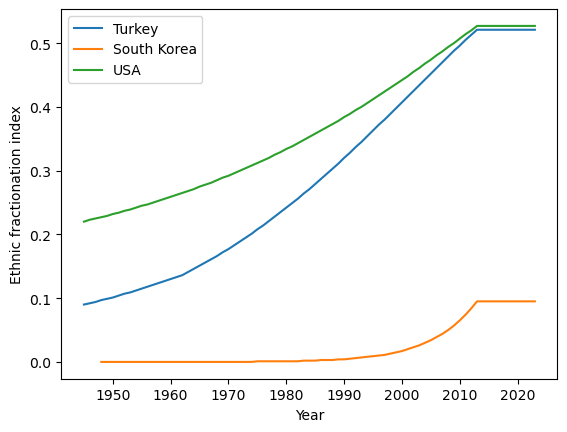

In [52]:
test = ethnic_fractionation[ethnic_fractionation['Entity']=='Turkey']
plt.plot(test['Year'], test['EFindex'], label='Turkey')

test = ethnic_fractionation[ethnic_fractionation['Entity']=='Republic of Korea']
plt.plot(test['Year'], test['EFindex'], label='South Korea')

test = ethnic_fractionation[ethnic_fractionation['Entity']=='United States of America']
plt.plot(test['Year'], test['EFindex'], label='USA')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Ethnic fractionation index')
plt.show()

In [53]:
# our gdp dataset we downloaded above
df = pd.read_csv("https://ourworldindata.org/grapher/gdp-worldbank-constant-usd.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})

df = df.drop('Entity', axis=1)
df = add_missing_years(df, min_year=1960,
                       max_year=2023,
                       year_name='Year',
                       ref_column='Code')

for country in df['Code'].unique():
    fill_na(df, 'ny_gdp_mktp_kd', 'Code', country, method='min')

df = df.sort_values(by=['Code', 'Year'])

df.sample(5)

,Code,Year,ny_gdp_mktp_kd
8318,PAK,1998,1.504052e+11
7849,NIC,1968,5.396573e+09
10312,NaN,2016,1.691001e+12
3302,SWZ,2001,2.398588e+09
8307,PAK,1987,9.360232e+10


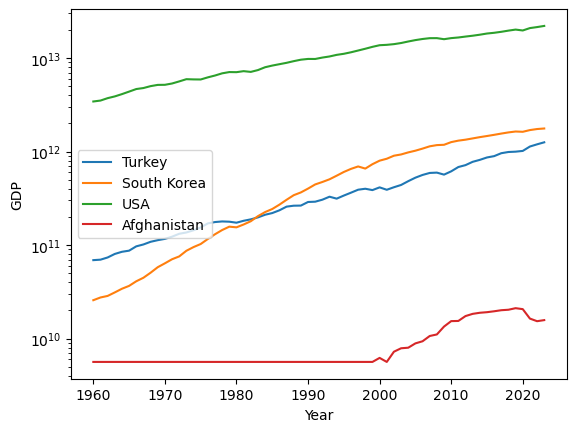

In [54]:
test = df[df['Code']=='TUR']
plt.plot(test['Year'], test['ny_gdp_mktp_kd'], label='Turkey')

test = df[df['Code']=='KOR']
plt.plot(test['Year'], test['ny_gdp_mktp_kd'], label='South Korea')

test = df[df['Code']=='USA']
plt.plot(test['Year'], test['ny_gdp_mktp_kd'], label='USA')

test = df[df['Code']=='AFG']
plt.plot(test['Year'], test['ny_gdp_mktp_kd'], label='Afghanistan')


plt.legend()
plt.xlabel('Year')
plt.ylabel('GDP')
plt.yscale('log')
plt.show()

In [55]:
ethnic_fractionation_with_code = ethnic_fractionation.merge(iso_name, on=['Entity'])
ethnic_fractionation_with_code.sample(10)

,Entity,Year,EFindex,Code
529,Austria,1963,0.065,AUT
4777,Italy,1990,0.073,ITA
2651,Denmark,1982,0.038,DNK
7167,Pakistan,1971,0.611,PAK
2405,Croatia,2022,0.325,HRV
4469,Iran,1997,0.743,IRN
9092,Switzerland,2017,0.367,CHE
1653,Cape Verde,1970,0.442,CPV
7048,Norway,2008,0.127,NOR
9694,Turkmenistan,1978,0.464,TKM


### Finally joining datasets

In [56]:
set1 = set(agricultural_share['Code'].unique())
set2 = set(oil_rent['Code'].unique())
set3 = set(df['Code'].unique())
set4 = set(ethnic_fractionation_with_code['Code'].unique())
set5 = set(world.iso_to_idx.keys())

print("Country codes in agriculture but not in oil rent")
print(set1.difference(set2))
print("Country codes in oil rent but not in agriculture")
print(set2.difference(set1))
print("Country codes in the gdp set but not in world")
print(set3.difference(set5))
print("Country codes in world but not in gdp")
print(set5.difference(set3))
print("Country code in ethnic but not in gdp")
print(set4.difference(set5))
print("Country code in gdp but not in ethnic")
print(set5.difference(set4))



Country codes in agriculture but not in oil rent
{'LIE', 'FSM', 'OWID_CIS', 'PLW', 'AND', 'MHL', 'SXM', 'IMN', 'SMR', 'CUW', 'TUV'}
Country codes in oil rent but not in agriculture
{'MAC', 'VIR', 'ASM', 'NRU', 'GUM'}
Country codes in the gdp set but not in world
{'OWID_WRL', 'SYC', 'NRU', 'ABW', 'MUS', 'VCT', 'SXM', 'IMN', 'PLW', 'PRI', 'MCO', 'LCA', 'SSD', 'GRL', 'BMU', 'FSM', 'OWID_CIS', nan, 'OWID_KOS', 'BRB', 'GRD', 'MDV', 'SMR', 'TON', 'CPV', 'STP', 'ISR', 'HKG', 'DMA', 'BHR', 'MHL', 'KNA', 'PSE', 'MLT', 'TUV', 'MAC', 'TCA', 'VIR', 'ASM', 'LIE', 'CHN', 'ATG', 'SGP', 'CYM', 'WSM', 'AND', 'GUM', 'MNP', 'KIR', 'NCL', 'PYF', 'CUW', 'COM'}
Country codes in world but not in gdp
{'SOL', 'KOS', 'ATA', 'SDS', 'SAH', 'VEN', 'TWN', 'PRK'}
Country code in ethnic but not in gdp
{'CHN', 'CPV', 'SGP', 'ISR', 'MUS', 'BHR', 'COM'}
Country code in gdp but not in ethnic
{'MKD', 'CZE', 'ISL', 'VUT', 'KOS', 'VNM', 'ATA', 'SUR', 'SDS', 'BLZ', 'DEU', 'GNQ', 'LUX', 'PNG', 'KGZ', 'FRA', 'SWZ', 'TWN', 'BHS

In [57]:
new_df = agricultural_share.merge(oil_rent, on=['Code', 'Year'])
new_df = new_df.merge(democracy_index, on=['Code', 'Year'])
new_df = new_df.merge(df, on=['Code', 'Year'])
new_df = new_df.merge(ethnic_fractionation_with_code, on=['Code', 'Year'])

new_df.rename(columns={'Code':'ISO3_code',
                       'nv_agr_totl_zs':'pt_gdp_agriculture',
                       'nv_gdp_petr_rt_zs':'pt_gdp_oil',
                       'ny_gdp_mktp_kd':'gdp',
                       'Entity':'country',
                       'EFindex': 'ethnic_fractionation_index'},
                       inplace=True)
new_df.reset_index(drop=True, inplace=True)
new_df.sample(20)

,ISO3_code,Year,pt_gdp_agriculture,ny_gdp_petr_rt_zs,democracy_polity,gdp,country,ethnic_fractionation_index
3555,GTM,1992,25.285048,0.185839,3.000000,2.688776e+10,Guatemala,0.557
2692,ESP,1961,4.379625,0.000151,-7.000000,2.140650e+11,Spain,0.443
9128,ZAF,1977,5.819972,0.000000,4.000000,1.398168e+11,South Africa,0.856
3441,GNB,2006,39.480423,0.000000,6.000000,8.452998e+08,Guinea-Bissau,0.808
8367,TJK,1986,33.052277,0.024253,-7.000000,6.777401e+09,Tajikistan,0.553
982,BHR,1979,0.337284,6.695589,-10.000000,7.892030e+09,Bahrain,0.437
1946,COM,1983,29.375513,0.000000,-3.000000,4.592696e+08,Comoros,0.060
8944,URY,1986,12.651819,0.000000,9.000000,2.324246e+10,Uruguay,0.191
6066,NAM,1991,9.973327,0.000000,6.000000,4.232046e+09,Namibia,0.722
7761,SLV,2020,5.354801,0.000065,-1.514286,2.374495e+10,El Salvador,0.222


## Add rainfall and surface temp data

In [58]:
countries = new_df['ISO3_code'].unique()
print(countries, len(countries))

['AFG' 'AGO' 'ALB' 'ARE' 'ARG' 'ARM' 'AUS' 'AUT' 'AZE' 'BDI' 'BEL' 'BEN'
 'BFA' 'BGD' 'BGR' 'BHR' 'BLR' 'BOL' 'BRA' 'BTN' 'BWA' 'CAF' 'CAN' 'CHE'
 'CHL' 'CHN' 'CIV' 'COD' 'COG' 'COL' 'COM' 'CPV' 'CRI' 'CUB' 'CYP' 'DJI'
 'DNK' 'DOM' 'DZA' 'ECU' 'EGY' 'ERI' 'ESP' 'EST' 'ETH' 'FIN' 'FJI' 'GAB'
 'GBR' 'GEO' 'GHA' 'GIN' 'GMB' 'GNB' 'GRC' 'GTM' 'GUY' 'HND' 'HRV' 'HTI'
 'HUN' 'IDN' 'IRL' 'IRN' 'IRQ' 'ISR' 'ITA' 'JAM' 'JOR' 'JPN' 'KAZ' 'KEN'
 'KHM' 'KOR' 'KWT' 'LAO' 'LBN' 'LBR' 'LBY' 'LKA' 'LSO' 'LTU' 'LVA' 'MAR'
 'MDA' 'MDG' 'MEX' 'MLI' 'MMR' 'MNG' 'MRT' 'MUS' 'MWI' 'MYS' 'NAM' 'NER'
 'NGA' 'NIC' 'NLD' 'NOR' 'NPL' 'NZL' 'OMN' 'PAK' 'PAN' 'PER' 'PHL' 'POL'
 'PRT' 'PRY' 'QAT' 'ROU' 'RUS' 'RWA' 'SAU' 'SDN' 'SEN' 'SGP' 'SLB' 'SLE'
 'SLV' 'SOM' 'SRB' 'SVK' 'SVN' 'SWE' 'SYR' 'TCD' 'TGO' 'THA' 'TJK' 'TKM'
 'TLS' 'TTO' 'TUN' 'TUR' 'TZA' 'UGA' 'UKR' 'URY' 'USA' 'UZB' 'ZAF' 'ZMB'
 'ZWE'] 145


In [59]:
yearly_rainfall = pd.DataFrame()
yearly_temp_avg = pd.DataFrame()
for country in countries:
    try:
        t, years, averages = rainfall.get_country_annual_avg((1960, 2023), country, world)
        variation = diff(averages)
        variation = np.concatenate(([variation[0]], variation))
        variation_t_1 = diff(averages, lag=1)
        variation_t_1 = np.concatenate(([variation_t_1[0], variation_t_1[0]], variation_t_1))
        to_add = pd.DataFrame({'ISO3_code': [country]*len(t), 'Year': years, 'yearly_avg_rainfall': averages, 'rainfall_var_t': variation, 'rainfall_var_t_1': variation_t_1})
        yearly_rainfall = pd.concat([yearly_rainfall, to_add])

        t, years, averages = surf_temp.get_country_annual_avg((1960, 2023), country, world)
        variation = diff(averages)
        variation = np.concatenate(([variation[0]], variation))
        variation_t_1 = diff(averages, lag=1)
        variation_t_1 = np.concatenate(([variation_t_1[0], variation_t_1[0]], variation_t_1))
        to_add = pd.DataFrame({'ISO3_code': [country]*len(t), 'Year': years, 'yearly_avg_temp': averages, 'temp_var_t': variation, 'temp_var_t_1': variation_t_1})
        yearly_temp_avg = pd.concat([yearly_temp_avg, to_add])
    except:
        continue

In [60]:
test = surf_temp.get_country_avg_at_time(5, 2010, 'AFG', world)
test

np.float64(186.23015873015873)

In [61]:
data = surf_temp.get_month(5, 2010)
idx = world.get_grid_points_of_country('AFG')
vals = data[idx]
vals

array([329., 322., 303., 289., 289., 298., 320., 321., 319., 315., 309.,
       301., 297., 286., 284., 258., 314., 306., 306., 306., 299., 281.,
       274., 266., 255., 311., 308., 299., 297., 295., 278., 274., 270.,
       258., 219., 302., 301., 297., 294., 286., 286., 281., 260., 262.,
       251., 233., 197., 194., 291., 287., 289., 274., 273., 263., 251.,
       265., 244., 223., 209., 219., 199., 190., 193., 198., 229., 274.,
       270., 267., 261., 240., 205., 192., 226., 216., 223., 189., 147.,
       179., 194., 195., 176., 171., 250., 233., 230., 210., 199., 180.,
       162., 162., 180., 195., 184., 139., 127., 135., 173., 171., 149.,
       199., 237., 223., 200., 163., 148., 143., 137., 133., 143., 143.,
       150., 134., 111., 100., 126., 151., 136., 157., 192., 233., 219.,
       212., 181., 163., 144., 131., 121., 115., 107., 107.,  99., 100.,
        92., 109., 140., 159., 144., 228., 206., 193., 179., 171., 159.,
       132., 119., 119., 104.,  86.,  80.,  71.,  6

In [62]:
yearly_temp_avg

,ISO3_code,Year,yearly_avg_temp,temp_var_t,temp_var_t_1
0,AFG,1960,116.206019,0.036755,0.036755
1,AFG,1961,120.477183,0.036755,0.036755
2,AFG,1962,117.250992,-0.026778,0.036755
3,AFG,1963,126.046296,0.075013,-0.026778
4,AFG,1964,110.172619,-0.125935,0.075013
...,...,...,...,...,...
59,ZWE,2019,224.837821,0.011953,0.012139
60,ZWE,2020,220.788462,-0.018010,0.011953
61,ZWE,2021,220.451923,-0.001524,-0.018010
62,ZWE,2022,219.669872,-0.003547,-0.001524


In [63]:
yearly_rainfall

,ISO3_code,Year,yearly_avg_rainfall,rainfall_var_t,rainfall_var_t_1
0,AFG,1960,318.565807,-0.075064,-0.075064
1,AFG,1961,294.653108,-0.075064,-0.075064
2,AFG,1962,243.503638,-0.173592,-0.075064
3,AFG,1963,307.702050,0.263645,-0.173592
4,AFG,1964,300.362434,-0.023853,0.263645
...,...,...,...,...,...
59,ZWE,2019,647.373718,0.176221,-0.316445
60,ZWE,2020,586.835256,-0.093514,0.176221
61,ZWE,2021,543.462821,-0.073909,-0.093514
62,ZWE,2022,635.176282,0.168758,-0.073909


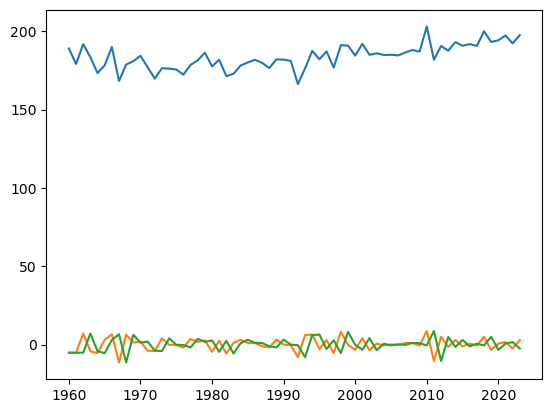

In [64]:
plt.plot(yearly_temp_avg[yearly_temp_avg['ISO3_code']=='SYR']['Year'], yearly_temp_avg[yearly_temp_avg['ISO3_code']=='SYR']['yearly_avg_temp'])
plt.plot(yearly_temp_avg[yearly_temp_avg['ISO3_code']=='SYR']['Year'], yearly_temp_avg[yearly_temp_avg['ISO3_code']=='SYR']['temp_var_t']*100)
plt.plot(yearly_temp_avg[yearly_temp_avg['ISO3_code']=='SYR']['Year'], yearly_temp_avg[yearly_temp_avg['ISO3_code']=='SYR']['temp_var_t_1']*100)

plt.show()

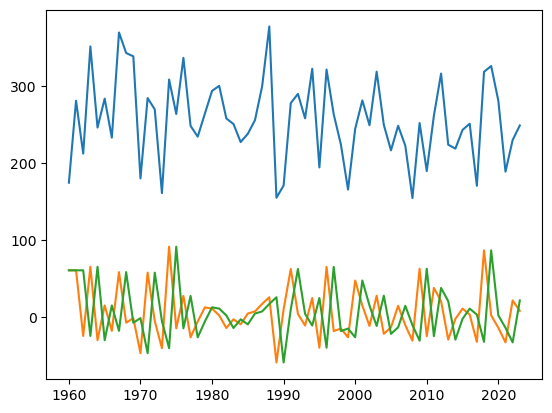

In [65]:
plt.plot(yearly_rainfall[yearly_rainfall['ISO3_code']=='SYR']['Year'], yearly_rainfall[yearly_rainfall['ISO3_code']=='SYR']['yearly_avg_rainfall'])
plt.plot(yearly_rainfall[yearly_rainfall['ISO3_code']=='SYR']['Year'], yearly_rainfall[yearly_rainfall['ISO3_code']=='SYR']['rainfall_var_t']*100)
plt.plot(yearly_rainfall[yearly_rainfall['ISO3_code']=='SYR']['Year'], yearly_rainfall[yearly_rainfall['ISO3_code']=='SYR']['rainfall_var_t_1']*100)

plt.show()

In [66]:
dataset = new_df.merge(yearly_rainfall, on=['ISO3_code', 'Year']).merge(yearly_temp_avg, on=['ISO3_code', 'Year'])

In [67]:
dataset.rename(columns={'ny_gdp_petr_rt_zs':'oil_rent'}, inplace=True)
dataset

,ISO3_code,Year,pt_gdp_agriculture,oil_rent,democracy_polity,gdp,country,ethnic_fractionation_index,yearly_avg_rainfall,rainfall_var_t,rainfall_var_t_1,yearly_avg_temp,temp_var_t,temp_var_t_1
0,AFG,1960,38.627890,0.005149,-10.000000,5.621148e+09,Afghanistan,0.586,318.565807,-0.075064,-0.075064,116.206019,0.036755,0.036755
1,AFG,1961,38.627890,0.005149,-10.000000,5.621148e+09,Afghanistan,0.588,294.653108,-0.075064,-0.075064,120.477183,0.036755,0.036755
2,AFG,1962,38.627890,0.005149,-10.000000,5.621148e+09,Afghanistan,0.591,243.503638,-0.173592,-0.075064,117.250992,-0.026778,0.036755
3,AFG,1963,38.627890,0.005149,-10.000000,5.621148e+09,Afghanistan,0.593,307.702050,0.263645,-0.173592,126.046296,0.075013,-0.026778
4,AFG,1964,38.627890,0.005149,-7.000000,5.621148e+09,Afghanistan,0.596,300.362434,-0.023853,0.263645,110.172619,-0.125935,0.075013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8848,ZWE,2019,9.819262,0.050883,-1.692308,2.062108e+10,Zimbabwe,0.415,647.373718,0.176221,-0.316445,224.837821,0.011953,0.012139
8849,ZWE,2020,8.772859,0.029129,-1.692308,1.900914e+10,Zimbabwe,0.415,586.835256,-0.093514,0.176221,220.788462,-0.018010,0.011953
8850,ZWE,2021,8.849899,0.047769,-1.692308,2.061884e+10,Zimbabwe,0.415,543.462821,-0.073909,-0.093514,220.451923,-0.001524,-0.018010
8851,ZWE,2022,7.170550,0.000000,-1.692308,2.188468e+10,Zimbabwe,0.415,635.176282,0.168758,-0.073909,219.669872,-0.003547,-0.001524


### Add features

- GDP variation (`gdp_g`)
- Rainfall difference from all-time average (`rainfall_diff_from_mean_norm`)
- Cumulative difference in rainfall from all-time mean (`cum_rainfall_diff`)
- Number of years in a row we are below average (`n_below_rainfall`)
- (Categorical variable) whether oil rent average over years is above 20% (`oil_prod`)
- (Categorical variable) whether % GDP due to agriculture average over years is above 40% (`agricultural`)

In [68]:
agriculture_cutoff = 30
oil_cutoff = 20

gdp_g = pd.DataFrame()
for country in dataset['ISO3_code'].unique():
    gdp = dataset[dataset['ISO3_code']==country].gdp
    gdp_diff = diff(gdp)
    gdp_diff = np.concatenate(([gdp_diff[0]], gdp_diff))
    gdp_diff[np.where(gdp_diff > 1)] = 0

    years = dataset[dataset['ISO3_code']==country].Year
    mean_rainfall = dataset[dataset['ISO3_code']==country].yearly_avg_rainfall.mean()
    avg_rainfall = dataset[dataset['ISO3_code']==country].yearly_avg_rainfall

    x = (avg_rainfall - mean_rainfall)/mean_rainfall

    n_below = []
    prev = 0
    for i, yr in enumerate(years):
        if avg_rainfall.to_list()[i] < mean_rainfall:
            prev += 1
        else:
            prev = 0
        n_below.append(prev)

    mean_oil = dataset[dataset['ISO3_code']==country].oil_rent.mean()
    mean_agr = dataset[dataset['ISO3_code']==country].pt_gdp_agriculture.mean()

    to_add = pd.DataFrame({'ISO3_code': [country]*len(gdp_diff),
                           'Year': years,
                           'gdp_g': gdp_diff,
                           'rainfall_diff_from_mean_norm': x,
                           'n_below_rainfall': n_below,
                           'oil_prod': [mean_oil >= oil_cutoff] * len(gdp_diff),
                           'agricultural': [mean_agr >= agriculture_cutoff] * len(gdp_diff),
                           'low_oil_high_agr': [(mean_oil < oil_cutoff) & (mean_agr >= agriculture_cutoff)] * len(gdp_diff),
                           'cum_rainfall_diff': np.cumsum(x)
                          })
    gdp_g = pd.concat([gdp_g, to_add])

dataset = dataset.merge(gdp_g, on=['ISO3_code', 'Year'])

dataset.sample(15)

,ISO3_code,Year,pt_gdp_agriculture,oil_rent,democracy_polity,gdp,country,ethnic_fractionation_index,yearly_avg_rainfall,rainfall_var_t,...,yearly_avg_temp,temp_var_t,temp_var_t_1,gdp_g,rainfall_diff_from_mean_norm,n_below_rainfall,oil_prod,agricultural,low_oil_high_agr,cum_rainfall_diff
5672,MYS,2005,8.262292,7.089441,3.000000,1.868988e+11,Malaysia,0.580,2348.331061,-0.001181,...,262.965909,0.001766,-0.001913,0.053321,-0.047935,2,False,False,False,-1.248839
1872,CUB,1965,13.040549,0.004771,-7.000000,2.312065e+10,Cuba,0.452,904.627193,-0.179888,...,252.076754,-0.004977,0.019495,0.000000,-0.183462,2,False,False,False,-0.202291
4951,LTU,1988,10.880504,0.008444,-6.000000,1.730084e+10,Lithuania,0.346,533.049550,-0.052125,...,64.896396,0.469577,-0.249780,0.000000,-0.042502,1,False,False,False,-0.558633
5707,NAM,1976,10.731025,0.000000,6.000000,3.425634e+09,Namibia,0.760,417.551215,0.714677,...,193.013021,-0.024832,0.019053,0.000000,0.627524,0,False,False,False,1.112828
6920,RWA,1970,61.618916,0.000000,-5.000000,1.314561e+09,Rwanda,0.183,889.452381,0.040397,...,182.607143,-0.015089,0.038336,0.060014,-0.047459,2,False,True,True,0.161705
6386,PAN,2015,2.949616,0.003715,9.000000,5.576781e+10,Panama,0.612,1822.787879,-0.043059,...,263.579545,0.003982,0.003795,0.052669,-0.075659,4,False,False,False,0.026121
7257,SLE,1984,38.578495,0.000000,-7.000000,3.739818e+09,Sierra Leone,0.799,1809.826389,-0.084583,...,260.934028,-0.010390,0.022941,0.040930,-0.137735,3,False,True,True,0.490576
966,BGR,2019,3.196165,0.018498,-3.287770,5.724855e+10,Bulgaria,0.289,445.787415,-0.217954,...,128.880952,0.037726,0.044257,0.037889,-0.151152,1,False,False,False,0.004297
4871,LSO,1975,36.508860,0.000000,-7.000000,4.041572e+08,Lesotho,0.271,840.909091,0.041882,...,111.803030,-0.000609,-0.022765,-0.135135,0.222417,0,False,False,False,0.084943
6113,NPL,1998,37.393010,0.000000,5.000000,1.211366e+10,Nepal,0.835,1035.984195,-0.008752,...,95.339080,0.138299,-0.112346,0.030164,0.110775,0,False,True,True,-0.000102


In [69]:
dataset.to_csv('dataset_rainfall.csv')